In [1]:

from google.colab import drive

# The following command will prompt a URL for you to click and obtain the
# authorization code

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
data_path="/content/drive/My Drive/Colab Notebooks/data/"

In [3]:
import json
import os
# import pandas as pd
import numpy as np
# df=pd.DataFrame()
count=0
dataset=[]
labels=[]
for folder in os.listdir(data_path):
  for filename in os.listdir(data_path+folder)[::]:
    with open(data_path+folder+"/"+filename) as f:
      data = json.load(f)
      if(int(data['label'])>0):
        # df=df.append(pd.json_normalize(data))
        li=[]
        for i in list(data['data'].keys()):
          npdata=np.array(data['data'][i])
          li.append(np.pad(npdata,(0,10000-len(npdata)),'constant'))  #some windows smaller than 256000
        ar=np.array(li)
        dataset.append(ar)
        labels.append(int(data['label']))
      count+=1
      if(count%100==0):
        print(count)
dataset1=np.array(dataset)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000


In [4]:
dataset1.shape

(1606, 23, 10000)

In [5]:
#Required Imports
%matplotlib inline
!pip install einops
!pip install seaborn
!pip install prettytable
!pip install sklearn
!pip install levenshtein
!pip install tensorflow
import gc
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import itertools
import random
from prettytable import PrettyTable
from IPython.display import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import euclidean_distances
from Levenshtein import distance as levenshtein_distance

from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GlobalMaxPooling1D


     |████████████████████████████████| 110 kB 11.7 MB/s 
     |████████████████████████████████| 854 kB 42.4 MB/s 


In [6]:
x_train=dataset1[:int(len(dataset1)*.6)]
x_val=dataset1[int(len(dataset1)*.6):int(len(dataset1)*.8)]
x_test=dataset1[int(len(dataset1)*.8):]
#shape of data
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
y_train=labels[:int(len(labels)*.6)]
y_val=labels[int(len(labels)*.6):int(len(labels)*.8)]
y_test=labels[int(len(labels)*.8):]
#shape of labels
print(len(y_train))
print(len(y_val))
print(len(y_test))
print("")
# One hot encoding of outputs
y_train_orig=y_train
y_val_orig=y_val
y_test_orig=y_test

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)
print(y_train.shape)

(963, 23, 10000)
(321, 23, 10000)
(322, 23, 10000)
963
321
322

(963, 10)


In [7]:
#Utility functions: plot model's accuracy and loss

# https://realpython.com/python-keras-text-classification/
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['rmse']
  val_acc = history.history['val_rmse']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

# Utility function: Display model score(Loss & Accuracy) across all sets.

def display_model_score(model, train, val, test, batch_size):

  train_score = model.evaluate(train[0], train[1], batch_size=batch_size, verbose=1)
  print('Train loss: ', train_score[0])
  print('Train accuracy: ', train_score[1])
  print('-'*70)

  val_score = model.evaluate(val[0], val[1], batch_size=batch_size, verbose=1)
  print('Val loss: ', val_score[0])
  print('Val accuracy: ', val_score[1])
  print('-'*70)
  
  test_score = model.evaluate(test[0], test[1], batch_size=batch_size, verbose=1)
  print('Test loss: ', test_score[0])
  print('Test accuracy: ', test_score[1])

In [8]:
# Evaluation function
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['1','2','3']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)
    

In [9]:
from tensorflow import keras
import tensorflow as tf

#CNN:

def network_CNN(X_train,y_train):
    
    im_shape = (23,10000)
    inputs_cnn=Input(shape=im_shape, name='inputs_cnn')

    #Convolution layer calcuations are based on: O = W-F+2P/S + 1
    
    #first convolution layer with filters=128, kernel_size=1
    conv1d_1 = tf.keras.layers.Conv1D(
        128, 1, strides=1,padding="valid",dilation_rate=1, activation='relu',input_shape=im_shape)(inputs_cnn)
    
    #batch normalization layer 
    batch_normalization = tf.keras.layers.BatchNormalization()(conv1d_1)

    #max pooling layer with pool_size=2, strides=2
    max_pooling1d = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(batch_normalization)

    #flatten to lower dimension
    flatten = Flatten()(max_pooling1d)

    #two dense layers
    dense = Dense(64, activation='relu')(flatten)
    dense_1 = Dense(32, activation='relu')(dense)

    #output with a softmax activation fxn to catagorize data
    main_output = Dense(10, activation='softmax')(dense_1)

   
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])

    return(model)

In [10]:

model = network_CNN(x_train,y_train)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_cnn (InputLayer)     [(None, 23, 10000)]       0         
                                                                 
 conv1d (Conv1D)             (None, 23, 128)           1280128   
                                                                 
 batch_normalization (BatchN  (None, 23, 128)          512       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 11, 128)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 64)                90176 

In [11]:
# Train you model

es = EarlyStopping(monitor='val_loss',patience=3, verbose=1)

history = model.fit(x_train, y_train,epochs=20, batch_size=32,validation_data=(x_val,y_val), callbacks=[es])

Epoch 1/20
31/31 [==============================] - 15s 102ms/step - loss: 2.0422 - accuracy: 0.3614 - val_loss: 1.8298 - val_accuracy: 0.3801
Epoch 2/20
31/31 [==============================] - 1s 39ms/step - loss: 1.1581 - accuracy: 0.6116 - val_loss: 1.2448 - val_accuracy: 0.6822
Epoch 3/20
31/31 [==============================] - 1s 39ms/step - loss: 0.8890 - accuracy: 0.7134 - val_loss: 0.9812 - val_accuracy: 0.7508
Epoch 4/20
31/31 [==============================] - 1s 39ms/step - loss: 0.6273 - accuracy: 0.7985 - val_loss: 0.7635 - val_accuracy: 0.8131
Epoch 5/20
31/31 [==============================] - 1s 45ms/step - loss: 0.6679 - accuracy: 0.7840 - val_loss: 0.7325 - val_accuracy: 0.8193
Epoch 6/20
31/31 [==============================] - 1s 47ms/step - loss: 0.4229 - accuracy: 0.8525 - val_loss: 0.5350 - val_accuracy: 0.8629
Epoch 7/20
31/31 [==============================] - 1s 44ms/step - loss: 0.3490 - accuracy: 0.8816 - val_loss: 0.5125 - val_accuracy: 0.8910
Epoch 8/20


Accuracy: 91.93%


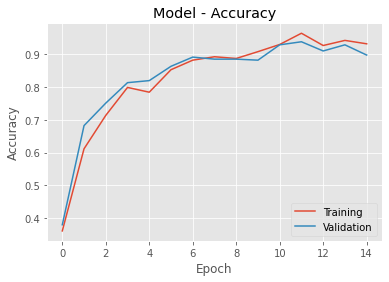

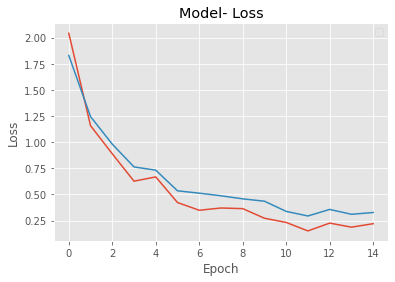

In [12]:
# Print result and plot accuracy and loss

from sklearn.metrics import confusion_matrix

evaluate_model(history,x_test,y_test,model)

In [13]:
# eval metric : 
scores = model.evaluate((x_test),y_test, verbose=0)
cnn_acc = "Accuracy of cnn model: %.2f%%" % (scores[1]*100)
print(cnn_acc)

Accuracy of cnn model: 91.93%


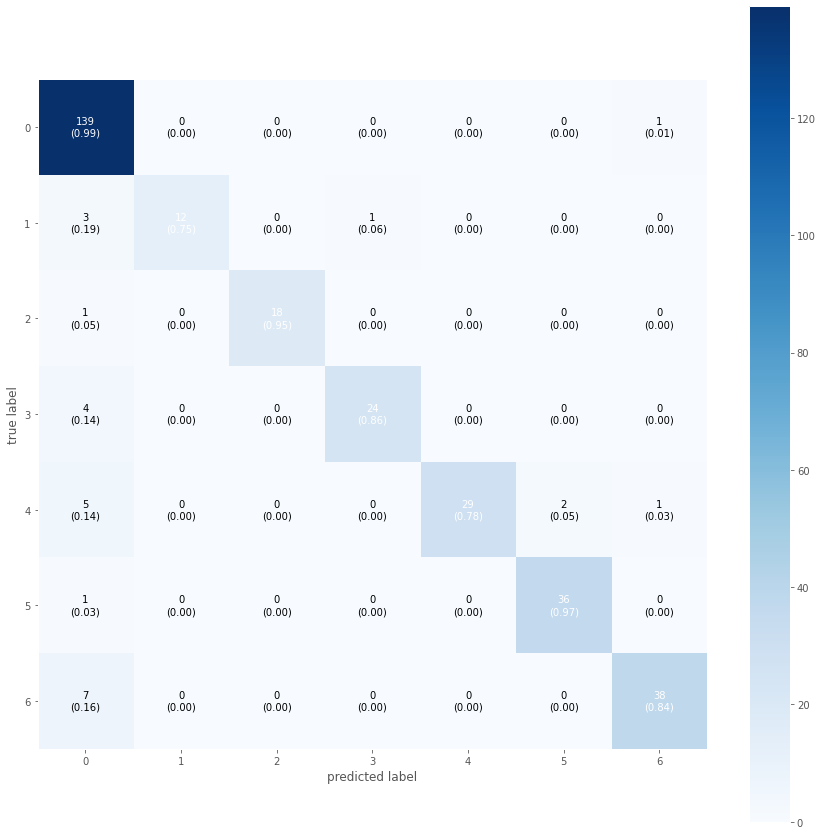

In [47]:
from mlxtend.plotting import plot_confusion_matrix    

y_pred=model.predict(x_test)

#maximum values in an axis
prediction = np.argmax(y_pred,axis=1)

import numpy as np
label=np.argmax(y_test, axis=1)
label[1]

#confution matrix based on x_test and y_pred
cnn_matrix = confusion_matrix(label, prediction)

#plot confusion matrices for each model

classes = ['0', '1', '2' , '3' , '4' , '5' , '6']

plot_1 = plot_confusion_matrix(conf_mat = cnn_matrix,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,
                                figsize=(15,15))


